In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
traffic_volume = pd.read_csv('traffic_Vol.csv', index_col=0)
throughput_time = pd.read_csv('traffic_DLThpTime.csv', index_col=0)
PRB_util = pd.read_csv('traffic_DLPRB.csv', index_col=0)
user_count = pd.read_csv('traffic_MR_number.csv', index_col=0)

In [3]:
def melt_df(df, value_name):
    return df.reset_index().melt(id_vars='index', var_name='timestamp', value_name=value_name).rename(columns={'index':'beam_id'})

traffic_long = melt_df(traffic_volume, 'traffic_volume')
throughput_long = melt_df(throughput_time, 'throughput_time')
PRB_long = melt_df(PRB_util, 'PRB_utilization')
users_long = melt_df(user_count, 'user_count')

In [4]:
df = traffic_long.merge(throughput_long, on=['beam_id','timestamp']) \
                 .merge(PRB_long, on=['beam_id','timestamp']) \
                 .merge(users_long, on=['beam_id','timestamp'])

In [5]:
df.head()

,beam_id,timestamp,traffic_volume,throughput_time,PRB_utilization,user_count
0,0,0_0_0,0.000000,0.000000,0.066698,0.000000
1,1,0_0_0,0.000000,0.000000,0.138920,0.000000
2,2,0_0_0,0.000000,0.014916,0.158870,0.173515
3,3,0_0_0,0.000000,0.000000,0.019840,0.000000
4,4,0_0_0,0.445035,0.000000,0.087727,0.062068


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2419200 entries, 0 to 2419199
Data columns (total 6 columns):
 #   Column           Dtype  
---  ------           -----  
 0   beam_id          int64  
 1   timestamp        object 
 2   traffic_volume   float64
 3   throughput_time  float64
 4   PRB_utilization  float64
 5   user_count       float64
dtypes: float64(4), int64(1), object(1)
memory usage: 110.7+ MB


In [7]:
df.isnull().sum()

beam_id            0
timestamp          0
traffic_volume     0
throughput_time    0
PRB_utilization    0
user_count         0
dtype: int64

In [8]:
# Split the timestamp string into day, hour, minute
df[['days', 'hours', 'minutes']] = df['timestamp'].str.split('_', expand=True).astype(int)

# Convert everything to total hours
df['time_hours'] = df['days']*24 + df['hours'] + df['minutes']/60

# Or as timedelta
df['time'] = pd.to_timedelta(df['days'], unit='d') + \
             pd.to_timedelta(df['hours'], unit='h') + \
             pd.to_timedelta(df['minutes'], unit='m')

# Set as index
df.set_index('time', inplace=True)

# Drop the original timestamp and temporary columns
df.drop(columns=['timestamp', 'days', 'hours', 'minutes'], inplace=True)

# Sort index
df.sort_index(inplace=True)


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
TimedeltaIndex: 2419200 entries, 0 days 00:00:00 to 29 days 02:31:00
Data columns (total 6 columns):
 #   Column           Dtype  
---  ------           -----  
 0   beam_id          int64  
 1   traffic_volume   float64
 2   throughput_time  float64
 3   PRB_utilization  float64
 4   user_count       float64
 5   time_hours       float64
dtypes: float64(5), int64(1)
memory usage: 129.2 MB


In [10]:
df.head()

,beam_id,traffic_volume,throughput_time,PRB_utilization,user_count,time_hours
time,,,,,,
0 days,0,0.000000,0.000000,0.066698,0.000000,0.0
0 days,1,0.000000,0.000000,0.138920,0.000000,0.0
0 days,2,0.000000,0.014916,0.158870,0.173515,0.0
0 days,3,0.000000,0.000000,0.019840,0.000000,0.0
0 days,4,0.445035,0.000000,0.087727,0.062068,0.0


In [11]:
df.tail()

,beam_id,traffic_volume,throughput_time,PRB_utilization,user_count,time_hours
time,,,,,,
29 days 02:31:00,835,0.148108,0.221450,0.000000,0.033925,698.516667
29 days 02:31:00,836,0.000000,0.000000,0.010537,0.406770,698.516667
29 days 02:31:00,837,0.063029,0.000000,0.000000,0.000000,698.516667
29 days 02:31:00,838,0.000000,0.122422,0.000000,0.428914,698.516667
29 days 02:31:00,839,0.109607,0.000000,0.069098,0.065389,698.516667


In [12]:
# Numerical columns
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numerical Columns:", num_cols)




Numerical Columns: ['beam_id', 'traffic_volume', 'throughput_time', 'PRB_utilization', 'user_count', 'time_hours']


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
TimedeltaIndex: 2419200 entries, 0 days 00:00:00 to 29 days 02:31:00
Data columns (total 6 columns):
 #   Column           Dtype  
---  ------           -----  
 0   beam_id          int64  
 1   traffic_volume   float64
 2   throughput_time  float64
 3   PRB_utilization  float64
 4   user_count       float64
 5   time_hours       float64
dtypes: float64(5), int64(1)
memory usage: 129.2 MB


In [14]:
df.describe()

,beam_id,traffic_volume,throughput_time,PRB_utilization,user_count,time_hours
count,2.419200e+06,2.419200e+06,2.419200e+06,2.419200e+06,2.419200e+06,2.419200e+06
mean,4.195000e+02,3.211692e-01,4.252134e-01,5.408694e-01,6.024467e-01,3.492583e+02
std,2.424870e+02,1.035234e+00,1.016166e+00,1.043146e+00,1.048595e+00,2.077323e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.097500e+02,0.000000e+00,0.000000e+00,8.083645e-03,3.573238e-02,1.692625e+02
50%,4.195000e+02,9.518060e-02,1.293085e-01,1.749911e-01,2.273421e-01,3.492583e+02
75%,6.292500e+02,2.862431e-01,3.873799e-01,5.546081e-01,6.868961e-01,5.292542e+02
max,8.390000e+02,2.453746e+02,8.420682e+01,4.102625e+01,3.366598e+01,6.985167e+02


In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
beam_id,2419200.0,419.500000,242.486991,0.0,209.750000,419.500000,629.250000,839.000000
traffic_volume,2419200.0,0.321169,1.035234,0.0,0.000000,0.095181,0.286243,245.374552
throughput_time,2419200.0,0.425213,1.016166,0.0,0.000000,0.129309,0.387380,84.206817
PRB_utilization,2419200.0,0.540869,1.043146,0.0,0.008084,0.174991,0.554608,41.026253
user_count,2419200.0,0.602447,1.048595,0.0,0.035732,0.227342,0.686896,33.665978
time_hours,2419200.0,349.258333,207.732299,0.0,169.262500,349.258333,529.254167,698.516667


### EDA

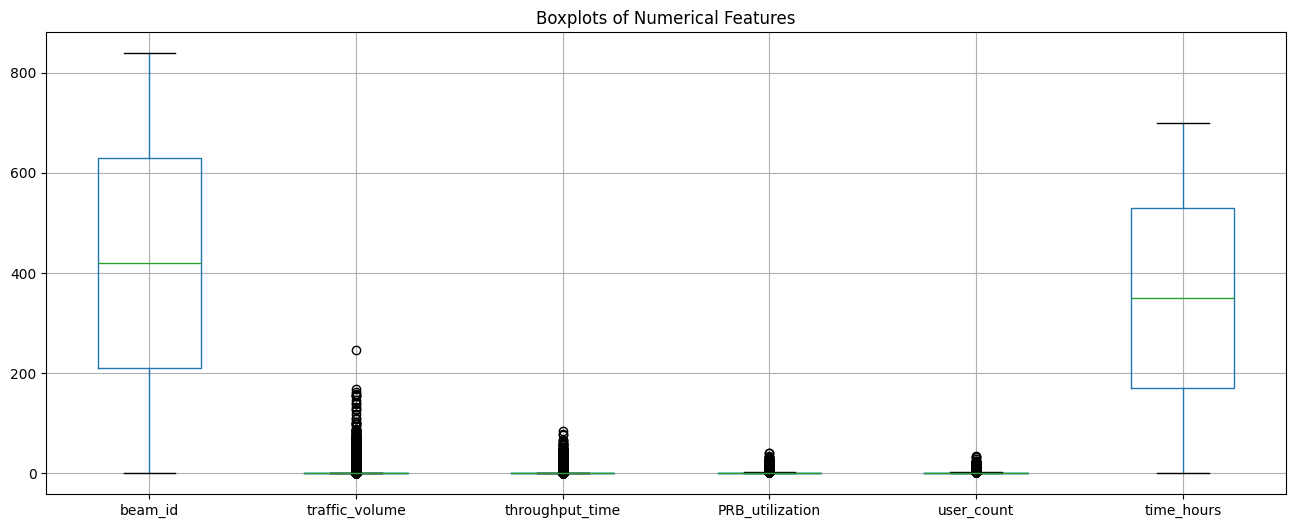

In [932]:
#  Boxplots for outliers
plt.figure(figsize=(16,6))
df[num_cols].boxplot()
plt.title('Boxplots of Numerical Features')
plt.show()

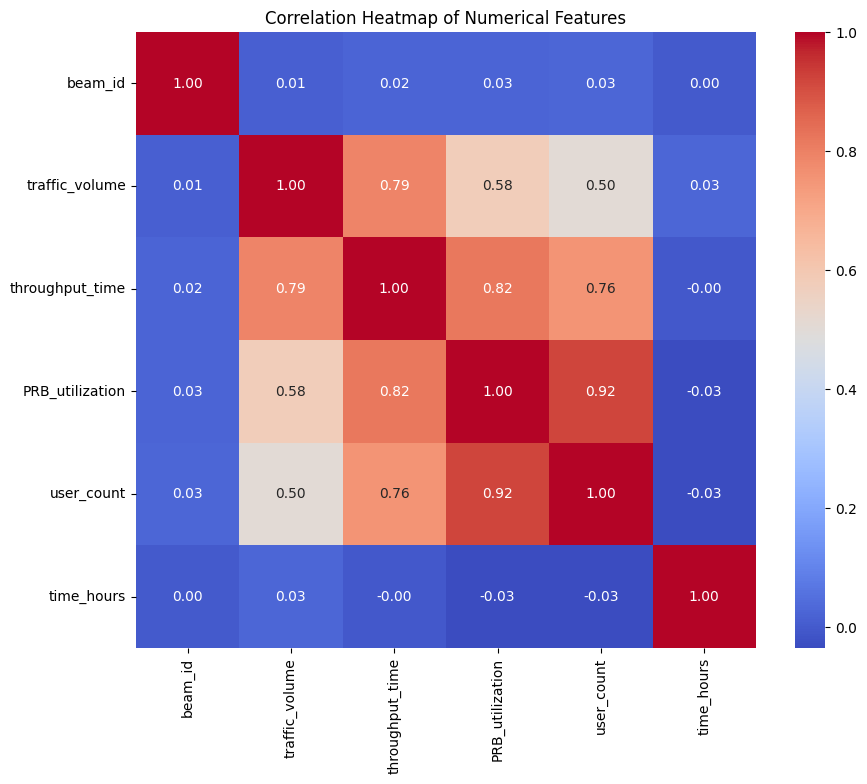

In [933]:
#  Heatmap for correlation 
plt.figure(figsize=(10,8))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

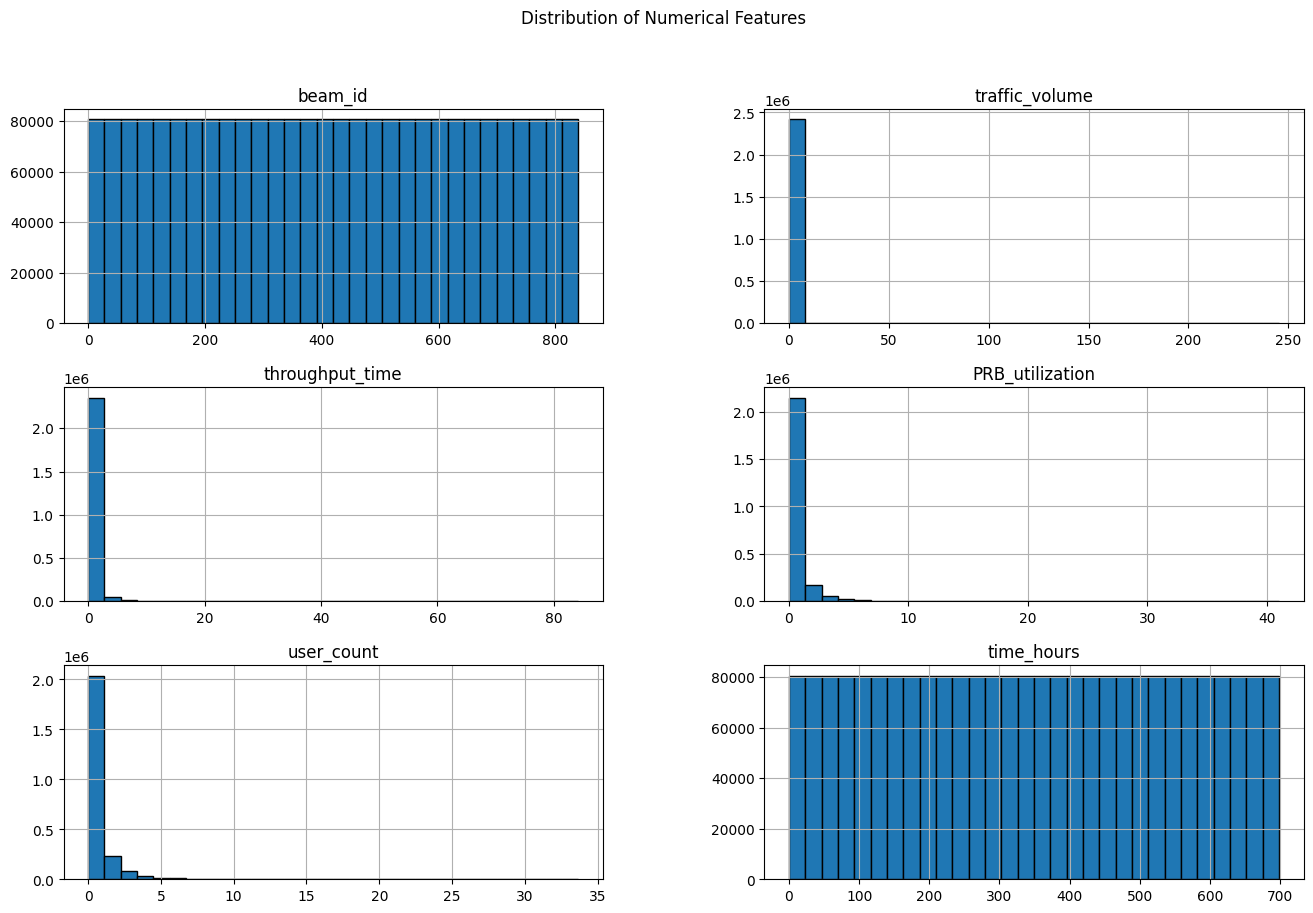

In [934]:
#  Histograms for distribution
df[num_cols].hist(figsize=(16,10), bins=30, edgecolor='black')
plt.suptitle('Distribution of Numerical Features')
plt.show()

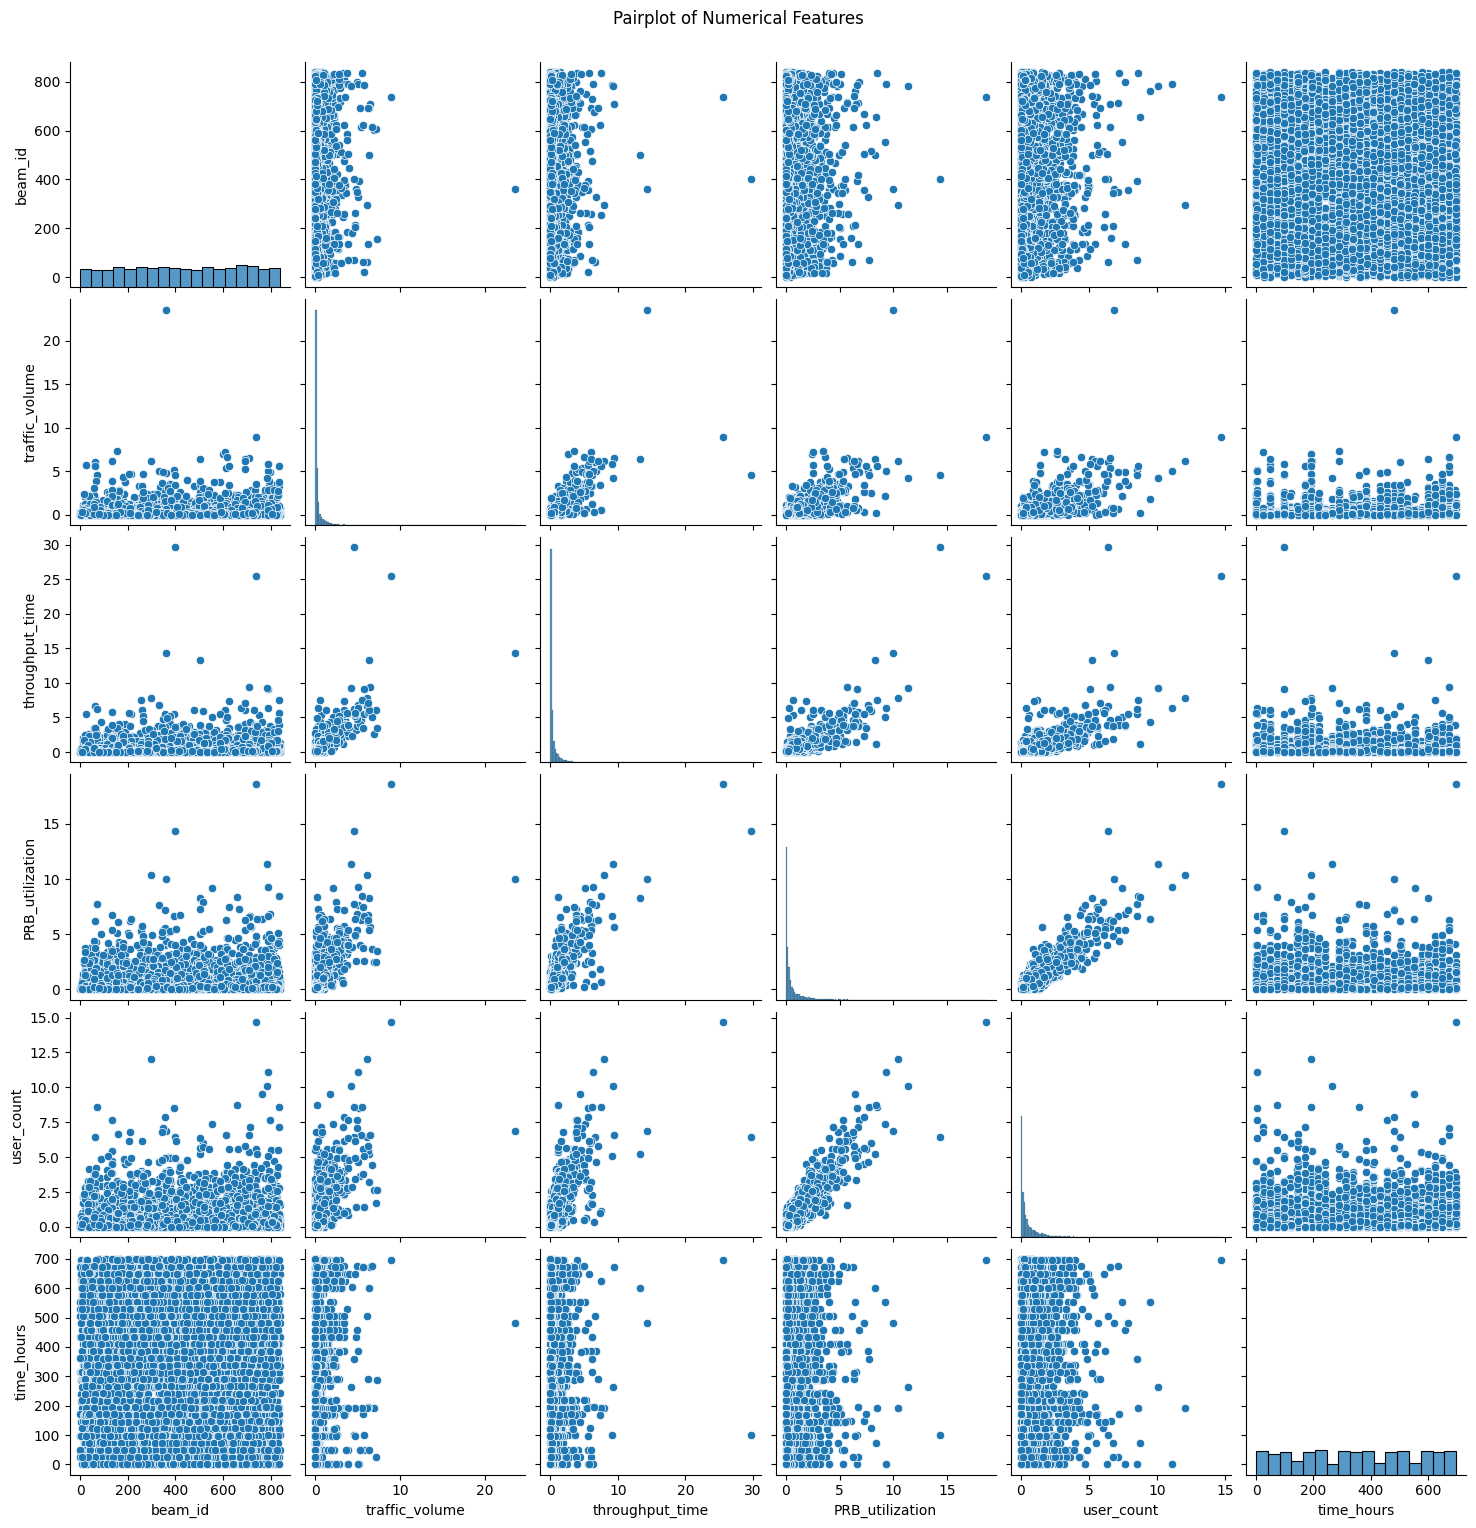

In [935]:
# Pairplot for relationships / linearity
sample_df = df[num_cols].sample(n=5000, random_state=42) if len(df) > 5000 else df[num_cols]
sns.pairplot(sample_df)
plt.suptitle('Pairplot of Numerical Features', y=1.02)
plt.show()

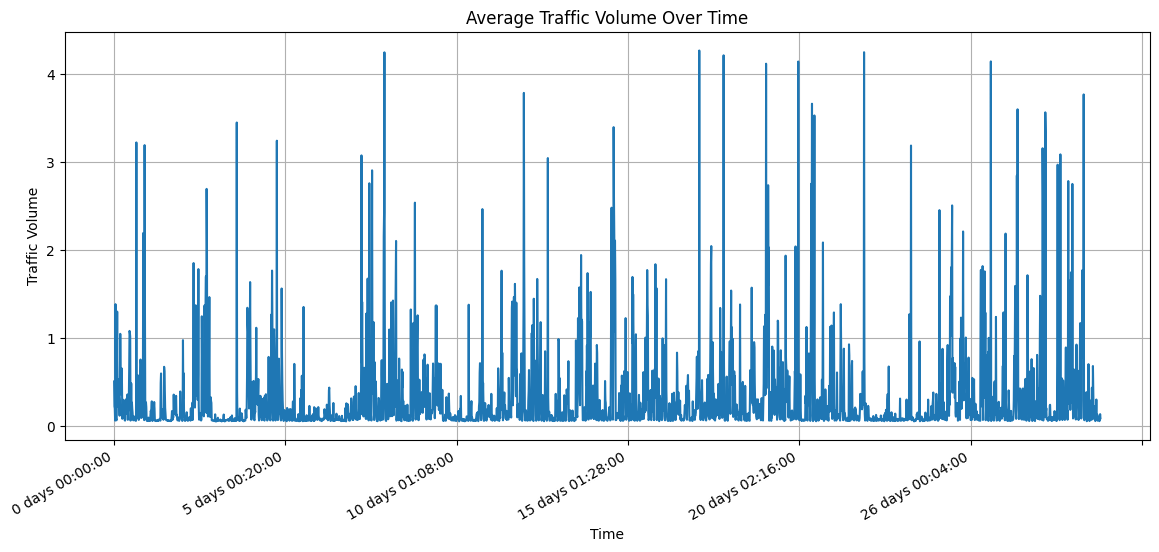

In [936]:
# Plot traffic volume over time (aggregate over all beams)
traffic_over_time = df.groupby(df.index)['traffic_volume'].mean()

plt.figure(figsize=(14,6))
traffic_over_time.plot(title='Average Traffic Volume Over Time')
plt.xlabel('Time')
plt.ylabel('Traffic Volume')
plt.grid(True)
plt.show()

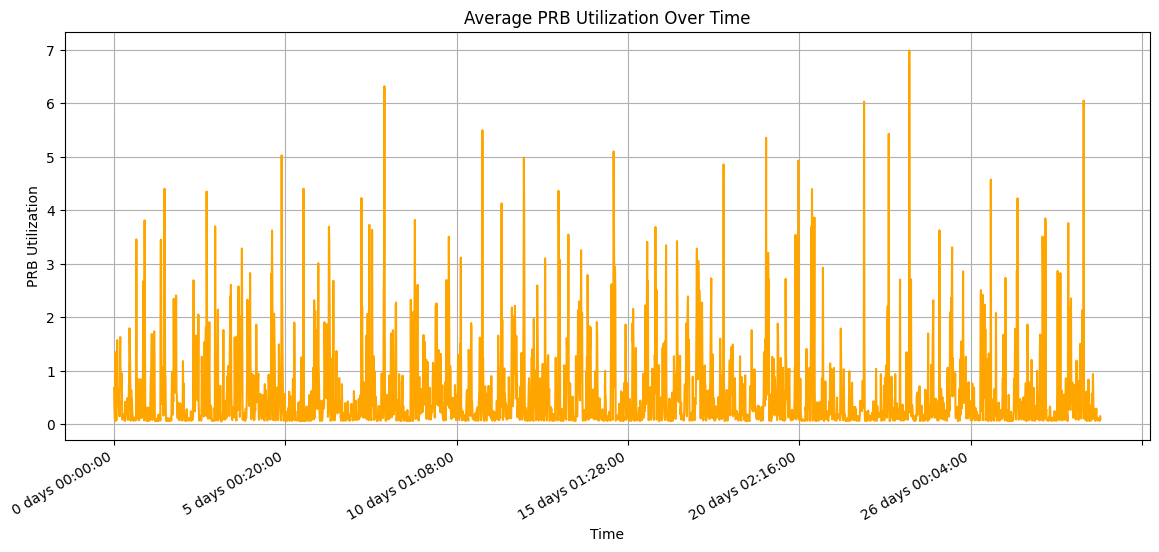

In [937]:
# Plot PRB utilization over time (aggregate)
prb_over_time = df.groupby(df.index)['PRB_utilization'].mean()

plt.figure(figsize=(14,6))
prb_over_time.plot(title='Average PRB Utilization Over Time', color='orange')
plt.xlabel('Time')
plt.ylabel('PRB Utilization')
plt.grid(True)
plt.show()

In [17]:
#  Resample all beams hourly
# -----------------------------
df['time_hours'] = pd.to_timedelta(df['time_hours'], unit='h')
df.set_index(['beam_id', 'time_hours'], inplace=True)


In [18]:
# Resample hourly per beam and interpolate
df_hourly = df.groupby(level=0).resample('1H', level=1).mean().interpolate()
print(f"Total rows after resampling: {len(df_hourly)}")

Total rows after resampling: 587160


In [19]:
#  Stationarity & seasonal decomposition on ONE beam

beam_id = df_hourly.index.get_level_values(0).unique()[0]
beam_df = df_hourly.xs(beam_id, level=0)

In [20]:
# Reset to numeric index for decomposition (because original is Timedelta)
beam_df_reset = beam_df.reset_index(drop=True)
beam_df_reset['t'] = np.arange(len(beam_df_reset))
beam_df_reset.set_index('t', inplace=True)

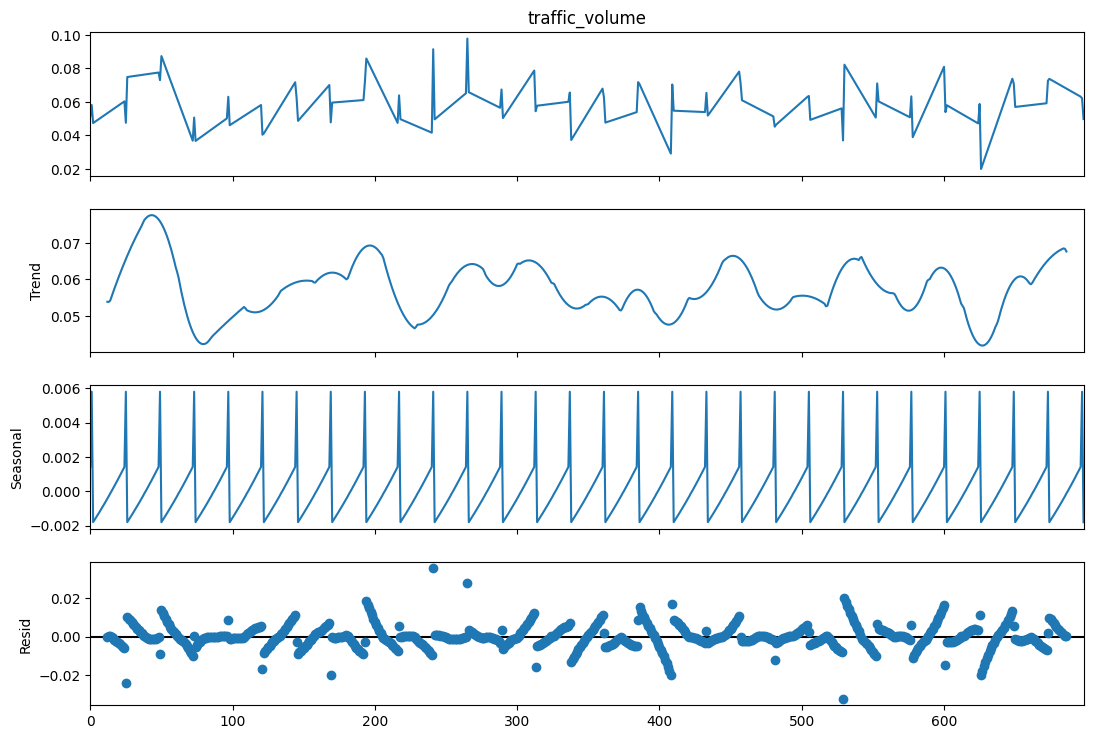

In [21]:
# Seasonal decomposition (period = 24 for hourly data → daily pattern)
decomposition = seasonal_decompose(beam_df_reset['traffic_volume'], period=24, model='additive')
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()

In [22]:
# ADF stationarity test
result = adfuller(beam_df_reset['traffic_volume'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Traffic volume is  stationary" if result[1]<=0.05 else "Traffic volume is likely non-stationary")

ADF Statistic: -5.104960025361903
p-value: 1.3700596505386487e-05
Traffic volume is  stationary


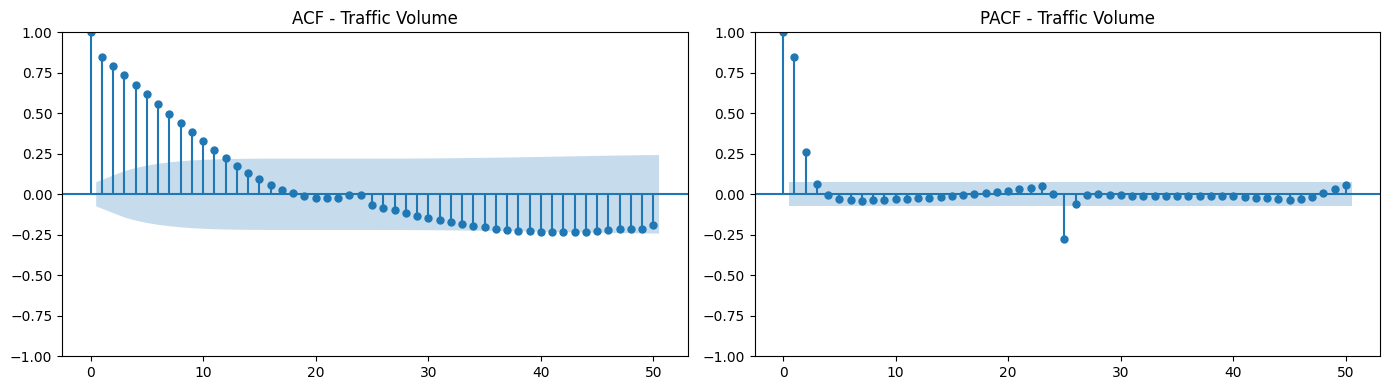

In [23]:
# ACF/PACF plots
fig, axes = plt.subplots(1, 2, figsize=(14,4))
plot_acf(beam_df_reset['traffic_volume'], ax=axes[0], lags=50)
plot_pacf(beam_df_reset['traffic_volume'], ax=axes[1], lags=50)
axes[0].set_title('ACF - Traffic Volume')
axes[1].set_title('PACF - Traffic Volume')
plt.tight_layout()
plt.show()

In [24]:
#  Feature engineering for all beams
# -----------------------------
df_hourly['lag1'] = df_hourly.groupby(level=0)['traffic_volume'].shift(1)
df_hourly['lag2'] = df_hourly.groupby(level=0)['traffic_volume'].shift(2)
df_hourly['roll3'] = df_hourly.groupby(level=0)['traffic_volume'].transform(lambda x: x.rolling(3, min_periods=1).mean())

# Extract hour from timedelta safely
df_hourly['hour'] = df_hourly.index.get_level_values(1).total_seconds() // 3600
df_hourly['sin_time'] = np.sin(2*np.pi*df_hourly['hour']/24)
df_hourly['cos_time'] = np.cos(2*np.pi*df_hourly['hour']/24)

In [25]:
df_hourly.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 587160 entries, (np.int64(0), Timedelta('0 days 00:00:00')) to (np.int64(839), Timedelta('29 days 02:00:00'))
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   traffic_volume   587160 non-null  float64
 1   throughput_time  587160 non-null  float64
 2   PRB_utilization  587160 non-null  float64
 3   user_count       587160 non-null  float64
 4   lag1             586320 non-null  float64
 5   lag2             585480 non-null  float64
 6   roll3            587160 non-null  float64
 7   hour             587160 non-null  float64
 8   sin_time         587160 non-null  float64
 9   cos_time         587160 non-null  float64
dtypes: float64(10)
memory usage: 47.1 MB


In [26]:
df_hourly.isnull().sum()

traffic_volume        0
throughput_time       0
PRB_utilization       0
user_count            0
lag1                840
lag2               1680
roll3                 0
hour                  0
sin_time              0
cos_time              0
dtype: int64

In [27]:
# Drop rows with NaN from lag features
df_hourly_clean = df_hourly.dropna(subset=['lag1','lag2'])




In [28]:
# Optional: reset index for ML/LSTM
df_hourly_clean_reset = df_hourly_clean.reset_index()

In [29]:
#  Prepare data for ML

features = ['lag1','lag2','roll3','throughput_time','PRB_utilization','user_count','sin_time','cos_time']
target = 'traffic_volume'

In [30]:
X = df_hourly_clean_reset[features]
y = df_hourly_clean_reset[target]
time_index = df_hourly_clean_reset['time_hours']  # keep for plotting

In [31]:
# Train/Validation/Test split
n_total = len(X)
train_size = int(n_total*0.7)
val_size = int(n_total*0.15)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val     = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test   = X[train_size+val_size:], y[train_size+val_size:]
test_index = time_index[train_size+val_size:]

print(f"Train: {len(y_train)}, Validation: {len(y_val)}, Test: {len(y_test)}")

Train: 409836, Validation: 87822, Test: 87822


In [32]:
#  XGBoost
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

In [33]:
#  Random Forest
rf = RandomForestRegressor(n_estimators=100,random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


In [34]:
#  ARIMA and SARIMA on single beam

beam_ts = beam_df_reset['traffic_volume']
train_len = int(len(beam_ts) * 0.7)
train_ts = beam_ts[:train_len]
test_len = len(beam_ts) - train_len

In [35]:
# ARIMA
print(" ARIMA Model ")
arima_order = (2, 0, 0)  # tune if needed
arima_model = ARIMA(train_ts, order=arima_order)
arima_fit = arima_model.fit()
y_pred_arima = arima_fit.forecast(steps=test_len)

 ARIMA Model 


In [36]:
# SARIMA
print("SARIMA Model")
sarima_order = (2, 0, 0)
seasonal_order = (1, 0, 1, 24)
sarima_model = SARIMAX(train_ts, order=sarima_order, seasonal_order=seasonal_order)
sarima_fit = sarima_model.fit(disp=False)
y_pred_sarima = sarima_fit.forecast(steps=test_len)

SARIMA Model


c:\Users\JOY\Desktop\TRAFFIC_FLOW\env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [37]:
#  LSTM

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1,1))

seq_len = 24
X_seq, y_seq = [], []
for i in range(seq_len, len(X_scaled)):
    X_seq.append(X_scaled[i-seq_len:i])
    y_seq.append(y_scaled[i])
X_seq, y_seq = np.array(X_seq), np.array(y_seq)

split_train = int(len(X_seq)*0.7)
split_val   = int(len(X_seq)*0.85)

X_train_seq, y_train_seq = X_seq[:split_train], y_seq[:split_train]
X_val_seq, y_val_seq     = X_seq[split_train:split_val], y_seq[split_train:split_val]
X_test_seq, y_test_seq   = X_seq[split_val:], y_seq[split_val:]

from tensorflow.keras.layers import LSTM, Dense, Dropout

lstm = Sequential()
lstm.add(LSTM(50, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=False))
lstm.add(Dropout(0.2))  # <-- added dropout for regularization
lstm.add(Dense(1))
lstm.compile(optimizer='adam', loss='mse')
lstm.fit(
    X_train_seq, y_train_seq,
    epochs=5,
    batch_size=32,
    validation_data=(X_val_seq, y_val_seq),
    verbose=1
)


Epoch 1/5
12807/12807 ━━━━━━━━━━━━━━━━━━━━ 101s 8ms/step - loss: 2.8415e-04 - val_loss: 1.2962e-04
Epoch 2/5
12807/12807 ━━━━━━━━━━━━━━━━━━━━ 96s 7ms/step - loss: 1.8404e-04 - val_loss: 1.2309e-04
Epoch 3/5
12807/12807 ━━━━━━━━━━━━━━━━━━━━ 101s 8ms/step - loss: 1.6087e-04 - val_loss: 1.0802e-04
Epoch 4/5
12807/12807 ━━━━━━━━━━━━━━━━━━━━ 99s 8ms/step - loss: 1.4563e-04 - val_loss: 8.6216e-05
Epoch 5/5
12807/12807 ━━━━━━━━━━━━━━━━━━━━ 92s 7ms/step - loss: 1.3822e-04 - val_loss: 8.0266e-05


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Define search space (keep small for speed)
units_list = [32, 64]
dropout_list = [0.2, 0.3]
lr_list = [1e-3, 1e-4]
batch_list = [32]

# Early stopping to avoid long training for bad combos
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

best_val_loss = float('inf')
best_config = None
best_model = None

# Grid search loop
for units in units_list:
    for dropout_rate in dropout_list:
        for lr in lr_list:
            for batch_size in batch_list:
                print(f"🔹 Trying: units={units}, dropout={dropout_rate}, lr={lr}, batch={batch_size}")

                # Build model
                model = Sequential()
                model.add(LSTM(units, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=False))
                model.add(Dropout(dropout_rate))
                model.add(Dense(1))

                optimizer = Adam(learning_rate=lr)
                model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

                history = model.fit(
                    X_train_seq, y_train_seq,
                    epochs=10,    # small number for speed
                    batch_size=batch_size,
                    validation_data=(X_val_seq, y_val_seq),
                    callbacks=[early_stop],
                    verbose=0    # set to 1 if you want to see training output
                )

                val_loss = min(history.history['val_loss'])

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_config = (units, dropout_rate, lr, batch_size)
                    best_model = model
                    print(f" New best val_loss={best_val_loss:.4f} with {best_config}")

#  Evaluate best model on test set
test_loss, test_mae = best_model.evaluate(X_test_seq, y_test_seq, verbose=0)
print(f" Best Hyperparameters: units={best_config[0]}, dropout={best_config[1]}, lr={best_config[2]}, batch={best_config[3]}")
print(f"Test MSE: {test_loss:.4f} | Test MAE: {test_mae:.4f}")

# Predict with the best model
y_pred_best_scaled = best_model.predict(X_test_seq)
y_pred_best = scaler_y.inverse_transform(y_pred_best_scaled)


 Trying: units=32, dropout=0.2, lr=0.001, batch=32
 New best val_loss=0.0001 with (32, 0.2, 0.001, 32)
 Trying: units=32, dropout=0.2, lr=0.0001, batch=32
 Trying: units=32, dropout=0.3, lr=0.001, batch=32
 Trying: units=32, dropout=0.3, lr=0.0001, batch=32
 Trying: units=64, dropout=0.2, lr=0.001, batch=32
 Trying: units=64, dropout=0.2, lr=0.0001, batch=32
 Trying: units=64, dropout=0.3, lr=0.001, batch=32
 Trying: units=64, dropout=0.3, lr=0.0001, batch=32

. Best Hyperparameters

Units: 32

Dropout: 0.2

Learning Rate: 0.001

Batch Size: 32

Test Performance

Test MSE: 0.0001

Test MAE: 0.0033

In [970]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict with tuned LSTM
y_pred_lstm_scaled = best_model.predict(X_test_seq)
y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm_scaled)
y_test_inv = scaler_y.inverse_transform(y_test_seq)

# Compute metrics
mse = mean_squared_error(y_test_inv, y_pred_lstm)
mae = mean_absolute_error(y_test_inv, y_pred_lstm)
r2 = r2_score(y_test_inv, y_pred_lstm)

print("Tuned LSTM Performance (Test):")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²:  {r2:.4f}")


2745/2745 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
Tuned LSTM Performance (Test):
MSE: 0.0050
MAE: 0.0253
R²:  0.9145


In [38]:
from sklearn.model_selection import RandomizedSearchCV

# Parameter distributions
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

In [39]:
# Randomized Search
rf_random = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=10,               # Number of combinations to try — increase for thorough tuning
    scoring='neg_mean_squared_error',
    cv=2,                    # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1
)

rf_random.fit(X_train, y_train)

print("Best RF Params:", rf_random.best_params_)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
Best RF Params: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 20}


In [41]:
# Refit best model and evaluate on validation/test
best_rf = rf_random.best_estimator_

y_pred_rf_val = best_rf.predict(X_val)
y_pred_rf_test = best_rf.predict(X_test)

print(" Tuned Random Forest Performance (Validation):")
print(f"MSE: {mean_squared_error(y_val, y_pred_rf_val):.4f}")
print(f"MAE: {mean_absolute_error(y_val, y_pred_rf_val):.4f}")
print(f"R²:  {r2_score(y_val, y_pred_rf_val):.4f}")

print(" Tuned Random Forest Performance (Test):")
print(f"MSE: {mean_squared_error(y_test, y_pred_rf_test):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_rf_test):.4f}")
print(f"R²:  {r2_score(y_test, y_pred_rf_test):.4f}")

 Tuned Random Forest Performance (Validation):
MSE: 0.0001
MAE: 0.0031
R²:  0.9981
 Tuned Random Forest Performance (Test):
MSE: 0.0001
MAE: 0.0030
R²:  0.9984


In [962]:
# Evaluation

def evaluate(y_true, y_pred, name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)
    print(f"{name} → MSE: {mse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

evaluate(y_test, y_pred_rf, 'Random Forest')
evaluate(y_test, y_pred_xgb, 'XGBoost')
evaluate(y_test[-len(y_pred_lstm):], y_pred_lstm, 'LSTM')
evaluate(y_test[:len(y_pred_arima)], y_pred_arima, 'ARIMA')
evaluate(y_test[:len(y_pred_sarima)], y_pred_sarima, 'SARIMA')

Random Forest → MSE: 0.000, MAE: 0.001, R2: 0.999
XGBoost → MSE: 0.000, MAE: 0.008, R2: 0.996
LSTM → MSE: 0.004, MAE: 0.021, R2: 0.929
ARIMA → MSE: 0.186, MAE: 0.304, R2: -1.000
SARIMA → MSE: 0.201, MAE: 0.328, R2: -1.157


In [ ]:
# Plot predictions

plt.figure(figsize=(16,6))
plt.plot(test_index[-len(y_pred_arima):], y_test[-len(y_pred_arima):], label='True', color='gray', alpha=0.7)
plt.plot(test_index[-len(y_pred_arima):], y_pred_arima, label='ARIMA', color='blue', alpha=0.8)
plt.plot(test_index[-len(y_pred_sarima):], y_pred_sarima, label='SARIMA', color='green', alpha=0.8)
plt.plot(test_index[-len(y_pred_rf):], y_pred_rf, label='Random Forest', color='orange', alpha=0.8)
plt.plot(test_index[-len(y_pred_xgb):], y_pred_xgb, label='XGBoost', color='red', alpha=0.8)
plt.plot(test_index[-len(y_pred_lstm):], y_pred_lstm, label='LSTM', color='purple', alpha=0.8)
plt.title('Traffic Volume Prediction - Multi-Model Comparison')
plt.xlabel('Time')
plt.ylabel('Traffic Volume')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [973]:
import joblib

# Save tuned Random Forest
joblib.dump(best_rf, "rf_model.pkl")

# Save feature scalers if you used any preprocessing
joblib.dump(scaler_X, "scaler_X.pkl")
joblib.dump(scaler_y, "scaler_y.pkl")


['scaler_y.pkl']

In [974]:
df_hourly['traffic_volume'].describe()


count    587160.000000
mean          0.331019
std           0.263862
min           0.017183
25%           0.137025
50%           0.255261
75%           0.459005
max           7.726631
Name: traffic_volume, dtype: float64